# Summary:
This notebook will cover applying **Named Entity Recognition (NER)** using **BERT** for tweet sentiment extraction.

# Table of contents
* [1. Data preparation](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Tokenize text and selected_text](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Generate data input for BERT](#Part1.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.3 Generate TensorDataset and DataLoader](#Part1.3_link)
* [2. Train the Named Entity Recognition model](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Model training](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Evaluate training performance](#Part2.2_link)
* [3. Model evaluation](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Predict extracted text using trained model for training datasets](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Compute jaccard similarity score for predictions on training datasets](#Part3.2_link)
* [4. Prediction on test datasets](#Part4_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk import sent_tokenize
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import tokenizers
import transformers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForTokenClassification
from sklearn.model_selection import train_test_split
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from tqdm import tqdm

In [2]:
base_dir="/Volumes/Yuchen_Drive/Tweet_Sentiment_Extraction/tweet-sentiment-extraction"
bert_vocab_path="/Volumes/Yuchen_Drive/bert/tokenizer_vocab"

In [3]:
class Config:
    max_len=128

In [4]:
train_df=pd.read_csv(os.path.join(base_dir,"train.csv"))
test_df=pd.read_csv(os.path.join(base_dir,"test.csv"))
print("training set: {}".format(train_df.shape))
print("testing set: {}".format(test_df.shape))
train_df.dropna(inplace=True)
print("training set after removing NA: {}".format(train_df.shape))

training set: (27481, 4)
testing set: (3534, 3)
training set after removing NA: (27480, 4)


In [5]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


<a id='Part1_link'></a>
# 1. Data preparation

In [8]:
tokenizer=BertWordPieceTokenizer(os.path.join(bert_vocab_path,"bert-base-uncased-vocab.txt"),lowercase=True)

<a id='Part1.1_link'></a>
## 1.1 Tokenize text and selected_text

In [9]:
def process_data(text,selected_text,tokenizer,sentiment):
    '''
    contexts correspond to text,
    answers correspond to selected_text
    '''
    idx0=None
    idx1=None
    sentiment_tag={"neutral":1,
                   "positive":2,
                   "negative":3}
    for i,char in enumerate(text):
        if text[i]==selected_text[0]:
            if text[i:i+len(selected_text)]==selected_text:
                idx0=i
                idx1=i+len(selected_text)
                break
    char_targets=[0]*len(text)
    if idx0 != None and idx1 != None:
        for i in range(idx0,idx1):
            char_targets[i]=1
    
    text_tok=tokenizer.encode(text)
    input_ids_orig=text_tok.ids
    input_offsets=text_tok.offsets
    
    target_idx=[]
    
    for i,(offset1,offset2) in enumerate(input_offsets):
        if sum(char_targets[offset1:offset2])>0:
            target_idx.append(i)
    
    targets=[0]*len(input_ids_orig)
    for idx in target_idx:
        targets[idx]=sentiment_tag[sentiment]
    return targets

In [10]:
tqdm.pandas()
train_df["target"]=train_df.progress_apply(lambda x:process_data(x.text,x.selected_text,tokenizer,x.sentiment),axis=1)
train_df["target"]=train_df["target"].apply(lambda x:x+[0]*(Config.max_len-len(x)))

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 27480/27480 [00:06<00:00, 4498.79it/s]


<a id='Part1.2_link'></a>
## 1.2 Generate data input for BERT

In [11]:
def bert_ner_input(sents,tokenizer,max_len):
    input_ids=[]
    token_type_ids=[]
    attention_masks=[]
    for sent in sents:
        inputs=tokenizer.encode(sent)
        input_id=inputs.ids
        attention_mask=inputs.attention_mask
        token_type_id=inputs.type_ids
        padding_length=max_len-len(input_id)
        input_id=input_id+([0]*padding_length)
        attention_mask=attention_mask+([0]*padding_length)
        token_type_id=token_type_id+([0]*padding_length)
        
        input_ids.append(torch.tensor(input_id).reshape(1,-1))
        token_type_ids.append(torch.tensor(token_type_id).reshape(1,-1))
        attention_masks.append(torch.tensor(attention_mask).reshape(1,-1))
    
    input_ids=torch.cat(input_ids,dim=0)
    token_type_ids=torch.cat(token_type_ids,dim=0)
    attention_masks=torch.cat(attention_masks,dim=0)
    
    return input_ids,token_type_ids,attention_masks
    

In [12]:
train_set,val_set=train_test_split(train_df,train_size=0.8,stratify=train_df.sentiment)

In [14]:
print("Number of samples in training set: {}".format(train_set.shape[0]))
print("Number of samples in validation set: {}".format(val_set.shape[0]))

Number of samples in training set: 21984
Number of samples in validation set: 5496


In [15]:
train_input_ids,train_token_type_ids,train_attention_masks=bert_ner_input(train_set.text.values.tolist(),tokenizer,max_len=128)
val_input_ids,val_token_type_ids,val_attention_masks=bert_ner_input(val_set.text.values.tolist(),tokenizer,max_len=128)


In [16]:
print(train_input_ids.shape)
print(train_token_type_ids.shape)
print(train_attention_masks.shape)

print(val_input_ids.shape)
print(val_token_type_ids.shape)
print(val_attention_masks.shape)

torch.Size([21984, 128])
torch.Size([21984, 128])
torch.Size([21984, 128])
torch.Size([5496, 128])
torch.Size([5496, 128])
torch.Size([5496, 128])


In [17]:
train_labels=torch.tensor(train_set.target.values.tolist())
val_labels=torch.tensor(val_set.target.values.tolist())

In [18]:
print(train_labels.shape)
print(val_labels.shape)

torch.Size([21984, 128])
torch.Size([5496, 128])


<a id='Part1.3_link'></a>
## 1.3 Generate TensorDataset and DataLoader

In [19]:
train_data=TensorDataset(train_input_ids,train_token_type_ids,train_attention_masks,train_labels)
val_data=TensorDataset(val_input_ids,val_token_type_ids,val_attention_masks,val_labels)


In [20]:
# BATCH_SIZE=128
BATCH_SIZE=8
train_loader=DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
val_loader=DataLoader(val_data,shuffle=True,batch_size=BATCH_SIZE)


In [21]:
input_ids,token_type_ids,attention_masks,labels=next(iter(train_loader))
print(input_ids.shape)
print(token_type_ids.shape)
print(attention_masks.shape)
print(labels.shape)

torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8, 128])


In [22]:
model=BertForTokenClassification.from_pretrained("bert-base-uncased",num_labels=4)

In [23]:
with torch.no_grad():
    loss,logits=model(input_ids,
                      token_type_ids=token_type_ids,
                      attention_mask=attention_masks,
                      labels=labels)

In [24]:
print(loss)
print(logits.shape)

tensor(1.4473)
torch.Size([8, 128, 4])


<a id='Part2_link'></a>
# 2. Train the Named Entity Recognition model

<a id='Part2.1_link'></a>
## 2.1 Model training

In [25]:
def compute_jaccard_similarity_bert_ner(input_id,pred,y,device):
    if device.type == 'cpu':
        pred=pred.numpy()
        y=y.numpy()
        input_id=input_id.numpy()
    else:
        pred=pred.cpu().numpy()
        y=y.cpu().numpy()
        input_id=input_id.cpu().numpy()
    tag=np.unique(y)[-1]
    pred1=input_id[pred==tag]
    y1=input_id[y==tag]
    return len(set(pred1).intersection(set(y1)))/len(set(pred1).union(set(y1)))

In [26]:
def bert_ner_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size,step_size,clip=1.0):
    step_dict={}
    model=model.to(device)
    step=1
    step_dict[1]={}
    valid_loss_min = np.Inf

    for epoch in np.arange(n_epochs):
        train_loss = 0.0
        train_jaccard = []
        val_loss = 0.0
        val_jaccard = []
        # Training
        model.train()
        for i,batch in enumerate(train_loader):
            optimizer.zero_grad()
            input_ids,token_type_ids,attention_masks,labels=batch[0].to(device),batch[1].to(device),batch[2].to(device),batch[3].to(device)
            loss,logits=model(input_ids,
                              token_type_ids=token_type_ids,
                              attention_mask=attention_masks,
                              labels=labels)
                                               
            train_loss += loss.item()*input_ids.shape[0]
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            scheduler.step()
            ## Update pred jaccard similarity for the training process
            #_, top_class = logits.topk(1,dim=2)
            for j in range(input_ids.shape[0]):
                seq_len=sum(attention_masks[j]>0).item()
                _, top_class = logits[j].topk(1,dim=1)
                input_id=input_ids[j][:seq_len]
                pred=top_class.squeeze()[:seq_len]
                y=labels[j][:seq_len]
                jaccard_score=compute_jaccard_similarity_bert_ner(input_id,
                                                                  pred,
                                                                  y,
                                                                  device)
                train_jaccard.append(jaccard_score)
            
            if (i+1)%step_size==0:
                ## validation
                with torch.no_grad():
                    model.eval()
                    for batch in val_loader:
                        input_ids,token_type_ids,attention_masks,labels=batch[0].to(device),batch[1].to(device),batch[2].to(device),batch[3].to(device)
                        loss,logits=model(input_ids,
                                          token_type_ids=token_type_ids,
                                          attention_mask=attention_masks,
                                          labels=labels)
                        ## Update loss and pred jaccard similarity for the validation process
                        val_loss += loss.item()*input_ids.shape[0]
                        for j in range(input_ids.shape[0]):
                            seq_len=sum(attention_masks[j]>0).item()
                            _, top_class = logits[j].topk(1,dim=1)
                            input_id=input_ids[j][:seq_len]
                            pred=top_class.squeeze()[:seq_len]
                            y=labels[j][:seq_len]
                            jaccard_score=compute_jaccard_similarity_bert_ner(input_id,
                                                                              pred,
                                                                              y,
                                                                              device)
                            val_jaccard.append(jaccard_score)
                        
                    ### write training/validation loss/accuracy
                    step_dict[step]["Train_Loss"]=train_loss/(step_size*batch_size)
                    step_dict[step]["Train_jaccard_sim"]=sum(train_jaccard)/len(train_jaccard)
                    step_dict[step]["Val_Loss"]=val_loss/len(val_loader.sampler)
                    step_dict[step]["Val_jaccard_sim"]=sum(val_jaccard)/len(val_jaccard)

                    print("Step: {}.. ".format(step),
                          "Train Loss: {:.3f}.. ".format(step_dict[step]["Train_Loss"]),
                          "Train jaccard similarity: {:.3f}.. ".format(step_dict[step]["Train_jaccard_sim"]),
                          "Validation Loss: {:.3f}.. ".format(step_dict[step]["Val_Loss"]),
                          "Validation jaccard similarity: {:.3f}.. ".format(step_dict[step]["Val_jaccard_sim"]))

                    ## save the model with the lowest val_loss and update valid_loss_min
                    if val_loss <= valid_loss_min:
                        print('Validation loss decreased -- Saving model -- \n')
                        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                        model_to_save.save_pretrained(save_path)
                        #torch.save(model.state_dict(), save_path)
                        valid_loss_min = val_loss
                    
                    step+=1
                    step_dict[step]={}
                    train_loss = 0.0
                    train_jaccard = []
                    val_loss = 0.0
                    val_jaccard = []
        
    step_df=pd.DataFrame.from_dict(step_dict,orient="index")
    step_df["step"]=step_df.index
    return model,step_df

In [27]:
model=BertForTokenClassification.from_pretrained("bert-base-uncased",num_labels=4)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

n_epochs=2
total_steps = len(train_loader)*n_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
save_path=os.path.join(base_dir,"bert_ner_models/Tweet_bert_ner_maxlen128_epoch2_batch8_step40_clip1")
model,step_df=bert_ner_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size=BATCH_SIZE,step_size=40,clip=1.0)
step_df.to_csv(os.path.join(base_dir,"bert_ner_models/Tweet_bert_ner_maxlen128_epoch2_batch8_step40_clip1.csv"),index=False)

<a id='Part2.2_link'></a>
## 2.2 Evaluate training performance

In [30]:
step_df=pd.read_csv(os.path.join(base_dir,"bert_ner_models/Tweet_bert_ner_maxlen128_epoch2_batch8_step80_clip1.csv"))

In [31]:
step_df.head()

,Train_Loss,Train_jaccard_sim,Val_Loss,Val_jaccard_sim,step
0,1.084990,0.074576,1.032407,0.044401,1
1,0.986260,0.208702,0.893344,0.292208,2
2,0.878029,0.391584,0.876465,0.492804,3
3,0.855039,0.333559,0.812596,0.440619,4
4,0.790397,0.413826,0.765401,0.440872,5


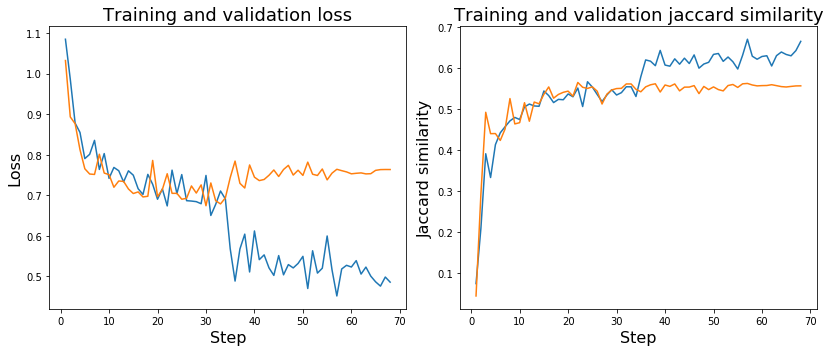

In [32]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
axes[0].plot(step_df.step,step_df.Train_Loss,label="Training loss")
axes[0].plot(step_df.step,step_df.Val_Loss,label="Validation loss")
axes[0].set_xlabel("Step",fontsize=16)
axes[0].set_ylabel("Loss",fontsize=16)
axes[0].set_title("Training and validation loss",fontsize=18)

axes[1].plot(step_df.step,step_df.Train_jaccard_sim,label="Training jaccard similarity")
axes[1].plot(step_df.step,step_df.Val_jaccard_sim,label="Validation jaccard similarity")
axes[1].set_xlabel("Step",fontsize=16)
axes[1].set_ylabel("Jaccard similarity",fontsize=16)
axes[1].set_title("Training and validation jaccard similarity",fontsize=18)
plt.tight_layout()

<a id='Part3_link'></a>
# 3. Model evaluation

<a id='Part3.1_link'></a>
## 3.1 Predict extracted text using trained model for training datasets

In [33]:
def decode_tweet(original_tweet,idx_start,idx_end,offsets):
    filtered_output  = ""
    for ix in range(idx_start, idx_end + 1):
        filtered_output += original_tweet[offsets[ix][0]: offsets[ix][1]]
        if (ix+1) < len(offsets) and offsets[ix][1] < offsets[ix+1][0]:
            filtered_output += " "
    return filtered_output

In [34]:
def bert_ner_pred(text,sentiment):
    sentiment_tag={"neutral":1,
                   "positive":2,
                   "negative":3}
    text_tok=tokenizer.encode(text)
    input_ids=torch.tensor([text_tok.ids]).to(device)
    with torch.no_grad():
        logits=model(input_ids)
    logit=logits[0][0]
    _, top_class = logit.topk(1,dim=1)
    pred=top_class.squeeze().numpy()
    
    indexes = list(np.where(pred==sentiment_tag[sentiment])[0])
    encoded_text = tokenizer.encode(text)
    if len(indexes)>0:
        start = indexes[0]
        end =  indexes[-1]
    else:
        start = 0
        end = len(encoded_text.ids) - 1
    if end >= len(encoded_text.ids):
        end = len(encoded_text.ids) - 1
    if start>end: 
        selected_text = test_df.loc[test_idx,'text']
    else:
        selected_text = decode_tweet(text,start,end,encoded_text.offsets)
    return selected_text

In [35]:
model=BertForTokenClassification.from_pretrained(os.path.join(base_dir,"bert_ner_models/Tweet_bert_ner_maxlen128_epoch2_batch8_step80_clip1"),num_labels=4)


In [36]:
tqdm.pandas()
train_df["bert_ner_predict"]=train_df.progress_apply(lambda x:bert_ner_pred(x.text,x.sentiment),axis=1)

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 27480/27480 [36:33<00:00, 12.53it/s] 


<a id='Part3.2_link'></a>
## 3.2 Compute jaccard similarity score for predictions on training datasets

In [37]:
def compute_jaccard_similarity(sent1,sent2):
    sents1=sent_tokenize(str(sent1).lower().strip())
    sents2=sent_tokenize(str(sent2).lower().strip())
    a=set()
    for sent in sents1:
        tokens=sent.split()
        a=a.union(set(tokens))
    b=set()
    for sent in sents2:
        tokens=sent.split()
        b=b.union(set(tokens))
    return len(a.intersection(b))/len(a.union(b))

In [38]:
train_df["bert_ner_jaccard"]=train_df.apply(lambda x:compute_jaccard_similarity(x.bert_ner_predict,x.selected_text),axis=1)


In [39]:
train_df.head()

,textID,text,selected_text,sentiment,target,bert_ner_predict,bert_ner_jaccard
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","I`d have responded, if I were going",1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,"[0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SAD I will miss,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,"[0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bullying me.,0.333333
3,9642c003ef,what interview! leave me alone,leave me alone,negative,"[0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, ...",leave me alone,1.000000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"[0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, ...","Sons of ****,",1.000000


In [40]:
train_df.to_csv(os.path.join(base_dir,"bert_ner_models/train_bert_ner_predict.csv"),index=False)

In [41]:
train_df=pd.read_csv(os.path.join(base_dir,"bert_ner_models/train_bert_ner_predict.csv"))

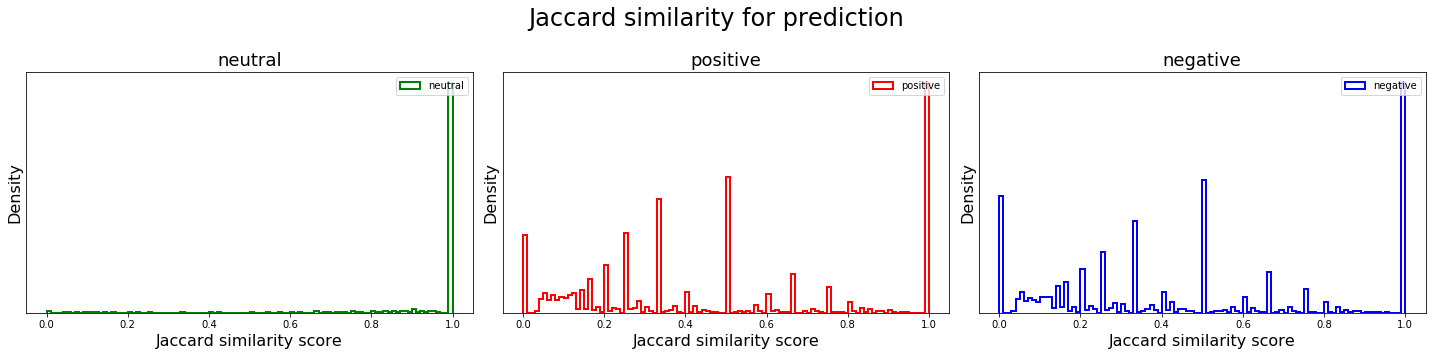

In [52]:
fig,axes=plt.subplots(1,3,figsize=(20,5))
sentiments=["neutral","positive","negative"]
colors=["green","red","blue"]
for i in range(3):
    sentiment=sentiments[i]
    axes[i].hist(train_df[train_df.sentiment==sentiment].bert_ner_jaccard,bins=100,histtype="step",color=colors[i],density=True,label=sentiment,linewidth=2)
    axes[i].set_xlabel("Jaccard similarity score",fontsize=16)
    axes[i].set_yticks([])
    axes[i].set_ylabel("Density",fontsize=16)
    axes[i].set_title(sentiment,fontsize=18)
    axes[i].legend()
fig.suptitle("Jaccard similarity for prediction",fontsize=24)
plt.tight_layout()
fig.subplots_adjust(top=0.8)

<a id='Part4_link'></a>
# 4. Prediction on test datasets

In [43]:
tqdm.pandas()
test_df["bert_ner_predict"]=test_df.progress_apply(lambda x:bert_ner_pred(x.text,x.sentiment),axis=1)

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 3534/3534 [04:14<00:00, 13.90it/s]


In [51]:
test_df.to_csv(os.path.join(base_dir,"bert_ner_models/test_bert_ner_predict.csv"),index=False)